# Team Orientering Problem

## Stochastic version

Implementation of the Sample Average Approsimation (SAA) algorithm applied to solve the Team Orientering Problem (TOP) modelled as a Stochastic Programming model.
The evaluation of the expected value of a given solution is done in several ways:

* solving a stochastic programming model with a large number of scenarios with the first stage variables (that define the routes) fixed, or
* running a simheuristic simulator.

The solution of the large 2nd-stage problem is solved **only for the best solution found**, while the simulator is run **for each solution**.

Instances: a selection of Chao.

In [1]:
import math
from pyomo.environ import *
from pyomo.opt import *

import scipy
import numpy as np
import random
import matplotlib.pyplot as plt
import cloudpickle
import os
import time 
import seaborn as sns
import pandas as pd
import shutil
import logging
logging.getLogger('pyomo.core').setLevel(logging.ERROR)

In [2]:
# Solver options --------------------------------------------------------
opt = SolverFactory("gurobi")     # Choose available solver: glpk gurobi cplex
solver_time = 300                 # Seconds that the solver has to solve a replica
opt.options['TimeLimit'] = solver_time  # set maximum solver time

# Instance definition ---------------------------------------------------
instanceName = 'p2.4.f'      # Name of the file with the data
dataName = './pythonChao/' + instanceName + '.dat'

# SAA parameters
np.random.seed(12345)
S = 25          # Number of scenarios for the 2-stage model
cVar = 0.05     # Variability level
S_large = 100  # Number of scenarios for evaluating the second stage
R = 10          # Replicas of the stochastic model
# Simulation 
num_sim = 10000 # Number of simulations used to estimate the stochastic obj. fun. of a given solution

## Model definition
### Sets and parameters

Dimensions:

* $n$: Number of locations
* $m$: Number of vehicles
* $s$: Number of scenarios


Sets:

* $N = \{0,1, ..., n, n+1\}$: Set of nodes composed of the customer locations $L = \{1, ..., n\}$, $\{0\}$ as the origin depot and $\{n+1\}$ as the arrival depot
* $M = \{1, ..., m\}$: Set of vehicles 
* $A = \{(i,j) \vert i \in N, j \in N, i \neq j\}$: Set of arcs connecting the locations
* $S = \{1, ..., s\}$: Set of travelling time scenarios

Parameters:

* $U_i$: Utility (reward) gained by visiting location $i$.
* $T_{ij}^s$: Travelling times between two locations in scenario $s$
* $t\_max$: Maximum time available per route

Build the set of scenarios for the random travelling time. The stochastic travel times are assumed to be distributed as a logNormal distribution with the same expected value as the deterministic value, and a variance proportional to this travelling time. Parameter $c$ reflects the level of uncertainty considered, and it modulates de variance of the time distributions in the arcs.

In [3]:
def stoch_times(model,i,j,s):
    time = model.time[i,j]
    if (time == 0): # Departure/Arrival depot
        return (time)
    if (cVar == 0): # Deterministic problem
        return (time)
    if (s == 1): # First scenario consider the deterministic scenario
        return (time)
    avg_t = time
    var_t = time*cVar
    mu = np.log(avg_t) - 0.5*np.log(1+var_t/(avg_t**2))
    sigma = np.sqrt(np.log(1+var_t/(avg_t**2)))
    
    return(round(np.random.lognormal(mu,sigma),1))

### Variables

First stage variables:
* $x_{ij}^k$: Whether vehicle $k$ goes from node $i$ to node $j$
* $y_{i}^k$: Position of node $i$ in the tour made by vehicle $k$

Second stage Stochastic variables:
* $z^{ks}$: Binary variable indicating whether route $k$ on scenario $s$ can be completed within the time frame
* $r^{ks}$: Total reward for route $k$ on scenario $s$

### Objective

For the deterministic version, the objective is to maximize the sum of the revenue collected by all vehicles which visit as many customers as possible within a time range. The vehicle/route is rewarded for each customer visited.

$$
\max \sum_{k=1}^m \sum_{(i,j) \in A} U_j x_{ij}^k 
$$

For the stochastic versions, given that the travelling times are uncertain, for each scenario a route will recieve the rewards collected on its route only when all the nodes can be visited within the given time frame. To compute this measure, the reward is computed within the constraint set, forcing to be zero for a particular route and scenario if the route cannot be fully accomplished within the time allowed.

$$
\max \frac{1}{S} \sum_{s=1}^S (\sum_{k=1}^m r^{ks})
$$

In [4]:
# Stochastic objective function
def Total_Utility_Stoch_rule(model):
    return (sum(model.r[k,s] for k in model.M for s in model.S)/(len(model.S)))

### Constraints

Each location can be visited at most once:

$$
\sum_{k=1}^m \sum_{(i,j) \in A} x_{ij}^k \le 1 \qquad j \in N
$$

In [5]:
def Visit_Once_rule(model, j):
    return (sum(model.x[i,j,k] for (i,jj,k) in model.A*model.M if jj==j)  <= 1)

Flow balance constraints: "Any arrival to a node has to be compensated with a departure"

$$
\sum_{i \in N} x_{ip}^k   =  \sum_{j \in N} x_{pj}^k   \qquad p \in L, k \in M
$$

In [6]:
def Balance_flow_rule(model,p,k):
    return sum(model.x[i,j,k] for (i,j) in model.A if i==p) - sum(model.x[i,j,k] for (i,j) in model.A if j==p) == 0

Prevent the construction of subtours:

$$
y_i - y_j + 1 \le (1-x_{ij}^k) n \qquad i \in N, j \in N, k \in M
$$
 which is equivalent to
$$
y_i - y_j + n x_{ij}^k \le n - 1 \qquad i \in N, j \in N, k \in M
$$

We also ensure that variables with equal origin and destination are fixed to 0.

In [7]:
def No_Subtours_rule(model,i,j,k):
    if (i != j):
        return (model.y[i] - model.y[j] + (model.n)*model.x[i,j,k] <= (model.n - 1))
    return model.x[i,j,k] == 0 # Remove diagonal elements

Capacity constraint: ensure that the expected time in traversing any route does not exceed a given threshold for a particular scenario $s$, and if so, the variable $z^{ks}$ is activated. $B$ is a 'large' value.

$$
\sum_{(i,j) \in A} T_{ij}^s x_{ij}^k \le t\_max  + B z^{ks} \qquad k \in M, s \in S
$$

In [8]:
def Max_Time_Stoch_rule(model, k, s):
    return (sum(model.time_stoch[i,j,s]*model.x[i,j,k] for (i,j) in model.A) - model.t_max*model.z[k,s] <= model.t_max)

Compute the rewards. Because $r^{ks}$ is maximized in the objective function, the optimization will favor the highest value, but if the route takes longer than allowed it will be forced to have a 0 reward.

$$
r^{ks} \le \sum_{(i,j) \in A} U_j x_{ij}^k \qquad k \in M, s \in S
$$

$$
r^{ks} \le big_M (1-z^{ks}) \qquad k \in M, s \in S
$$

In [9]:
def Reward_scn_rule(model,k,s):
    return(model.r[k,s] <= sum(model.utility[j]*model.x[i,j,k] for (i,j) in model.A))

def Reward_full_Route_rule(model, k, s):
    bigM = 1000
    return(model.r[k,s] <= bigM*(1-model.z[k,s]))

Ensure that each vehicle departs from the depot:

$$
\sum_{j=1}^n x_{0j}^k = 1 \qquad k \in M
$$

In [10]:
def Departures_rule(model, k):
    return sum(model.x[i,j,k] for (i,j) in model.A if i == 0) == 1

Ensure that all vehicles reach the arrival depot:

$$
\sum_{i=1}^n\sum_{k=1}^m x_{i,n+1}^k = 1 \qquad k \in M
$$

In [11]:
def Arrivals_rule(model, k):
    return sum(model.x[i,j,k] for (i,j) in model.A if j == (model.n-1)) == 1

No arrivals at the depot.

In [12]:
def No_arrivals_depot_rule(model):
    return(sum(model.x[i,j,k] for (i,j,k) in model.A*model.M if j == 0) == 0)

In [13]:
def build_mod(sizeScnTree = 10):
    mod = AbstractModel("Stochastic mod")
    
    mod.m = Param(within=PositiveIntegers) # Number of vehicles
    mod.M = RangeSet( mod.m )              # Set of Vehicles

    mod.n = Param(within=PositiveIntegers) # Number of locations to visit
    mod.L = RangeSet( mod.n - 2 )          # Set of locations
    mod.depar = Set(initialize = [0])      # Departure depot
    mod.arriv = RangeSet( mod.n - 1, mod.n - 1) # Arrival depot
    mod.N = mod.depar | mod.L | mod.arriv  # Set of nodes

    mod.A = Set(initialize = mod.N*mod.N)  # Set of arcs

    mod.time    = Param(mod.N, mod.N, within=NonNegativeReals, default = 0) # Travelling time between two pairs of locations

    mod.t_max   = Param(within=PositiveReals) # Maximum travelling time
    mod.utility = Param(mod.N, default = 0)   # Utility/reward gained by visiting each location

    mod.nScn = sizeScnTree # Number of scenarios
    mod.S = RangeSet(sizeScnTree)          # Set of scenarios

    mod.time_stoch = Param(mod.N, mod.N, mod.S, initialize = stoch_times, mutable = True)

    # Variables
    mod.x = Var(mod.A, mod.M, within=Binary)
    mod.y = Var(mod.N, within=NonNegativeReals)

    mod.z = Var(mod.M, mod.S, within = Binary)
    mod.r = Var(mod.M, mod.S, within = NonNegativeReals)

    # Objective Function
    mod.Total_Utility_Stoch = Objective(rule=Total_Utility_Stoch_rule, sense = maximize)

    # Constraints
    mod.Visit_Once        = Constraint(mod.L,               rule = Visit_Once_rule)
    mod.Balance_flow      = Constraint(mod.L, mod.M,        rule = Balance_flow_rule)
    mod.No_Subtours       = Constraint(mod.N, mod.N, mod.M, rule = No_Subtours_rule)
    mod.Max_Time_Stoch    = Constraint(mod.M, mod.S,        rule = Max_Time_Stoch_rule)
    mod.Reward_scn        = Constraint(mod.M, mod.S,        rule = Reward_scn_rule)
    mod.Reward_full_Route = Constraint(mod.M, mod.S,        rule = Reward_full_Route_rule)
    mod.Max_Departures    = Constraint(mod.M,               rule = Departures_rule)
    mod.Arrivals          = Constraint(mod.M,               rule = Arrivals_rule)
    mod.No_arrivals_depot = Constraint(                     rule = No_arrivals_depot_rule)
        
    return(mod)


In [14]:
modelSP = build_mod(S)
instanceSP = modelSP.create_instance(dataName)

### Sample Average Approximation

Start iterating to solve the problem by means of the **Sample Average Approximation**:
* Solve a number of replicas of the full stochastic model with a limited number of scenarios ($S$)
* Choose the solution with the best objective and solve the model with the 1st stage decision variables fixed. Use a large number of scenarios ($S_{2stg}$)


The parameters used are:
* $R$: Number of replicas
* $S_{2stg}$: Number of scenarios considered to evaluate the model with the 1st stage fixed

From this computations we will compute:
* $Z_{S}^r$: The objective function of the solution for the $r$ scenario tree (replica) with $S$ scenarios
* $Z_{S}$: The average objective function of the solution for the $r$ solutions found
* $\sigma^2_{Z_{S}}$ Variance of the objective function values obtained with the $R$ replicas
* $Z_{S_{2stg}}$ The objective function of the problem with $S_{2stg}$ scenarios and the 1st stage variables fixed
* $\sigma^2_{Z_{S_{2stg}}}$: Variance of the values of the different $S_{2stg}$ scenarios of the large scenario tree

In [15]:
# Number of replicas
num_replicas = range(R)

# To store the solutions of the full model
x_r = pd.Series([0 ]*len(num_replicas)*len(instanceSP.A*instanceSP.M), index=pd.MultiIndex.from_product([num_replicas,instanceSP.N,instanceSP.N,instanceSP.M]))
y_r = pd.Series([0 ]*len(num_replicas)*len(instanceSP.N*instanceSP.M), index=pd.MultiIndex.from_product([num_replicas,instanceSP.N,instanceSP.M]))
# Objective function solution
Z_det   = pd.Series([0 ]*len(num_replicas), index=num_replicas)
Z_R     = pd.Series([0 ]*len(num_replicas), index=num_replicas)
Z_Rsim  = pd.Series([0 ]*len(num_replicas), index=num_replicas, dtype='float')
# Variance of a particular solution
V_Rsim = pd.Series([0.]*len(num_replicas), index=num_replicas, dtype='float')

In [16]:
%run TOP_extras.ipynb

In [17]:
StartTime = time.time()

for r in num_replicas:  # For each replica
    print("\n----------------------------- Replica "+str(r+1))
    # Populate the small SP tree to find (another) solution
    for i,j,s in instanceSP.N*instanceSP.N*instanceSP.S:
        instanceSP.time_stoch[i,j,s] = stoch_times(instanceSP,i,j,s)
        
    #instanceSP.preprocess();  # Update to new values (needed in previous versions of Pyomo)

    results_SP = opt.solve(instanceSP, tee=False, warmstart = True) #, symbolic_solver_labels=True )
    print("   Solver time: ",round(results_SP.solver.time,2))
    print_solver_info(instanceSP, results_SP)
    
    # Store the results
    #instanceSP.solutions.load_from(results_SP)
    
    # Compute metrics
    utility_det = round(sum(instanceSP.utility[j]*instanceSP.x[i,j,k].value for (i,j,k) in instanceSP.A*instanceSP.M),1)
    Z_det[r] = utility_det
    utility_sto = round(instanceSP.Total_Utility_Stoch(),2)
    Z_R[r] = utility_sto
    
    print_solutionXvehicle(instanceSP)
    print4simulator(instanceSP)
    
    [avg_rew,std_rew,min_rew,max_rew,avg_rel] = simulate_sol(instanceName,num_sim)
    Z_Rsim[r] = avg_rew
    V_Rsim[r] = round((std_rew**2)/num_sim,4)
    
    print("Replica ",r+1, " with stoch OF ", utility_sto," det OF equiv ", utility_det, 
          "LB: Py simulator OF ", avg_rew, " std LB ", V_Rsim[r])
    
    # Save the solution
    for i,j,k in instanceSP.A*instanceSP.M:
        x_r[r,i,j,k] = instanceSP.x[i,j,k].value
        y_r[r,i,k]   = instanceSP.y[i].value
        




----------------------------- Replica 1
   Solver time:  300.4
p2.4.f ;  21 ;  99.4 ;  101.21 ;  300.4 ;  aborted ;  maxTimeLimit ;
 Vehicle 1:(0,5:15)(5,20:0) - total time 7.38 - total reward (det) 15
 Vehicle 2:(0,9:20)(9,20:0) - total time 7.04 - total reward (det) 20
 Vehicle 3:(0,11:10)(10,12:10)(11,10:15)(12,13:25)(13,20:0) - total time 6.58 - total reward (det) 60
 Vehicle 4:(0,6:10)(6,20:0) - total time 4.18 - total reward (det) 10
Replica  1  with stoch OF  99.4  det OF equiv  105.0 LB: Py simulator OF  92.2  std LB  0.0303

----------------------------- Replica 2
   Solver time:  300.35
p2.4.f ;  21 ;  98.2 ;  124.03 ;  300.35 ;  aborted ;  maxTimeLimit ;
 Vehicle 1:(0,5:15)(5,20:0) - total time 7.38 - total reward (det) 15
 Vehicle 2:(0,10:15)(10,13:25)(13,20:0) - total time 5.73 - total reward (det) 40
 Vehicle 3:(0,9:20)(9,20:0) - total time 7.04 - total reward (det) 20
 Vehicle 4:(0,6:10)(6,11:10)(11,12:10)(12,20:0) - total time 5.24 - total reward (det) 30
Replica  2  w

In [18]:
modelLarge = build_mod(S_large)
instanceLarge = modelLarge.create_instance(dataName)


---------------------- EVALUATE THE BEST SP SOLUTION IN A LARGE TREE  with  100  scn

Best solution:  4  with SP objective function:  96.6  -  95.6
   Solver time:  0.15


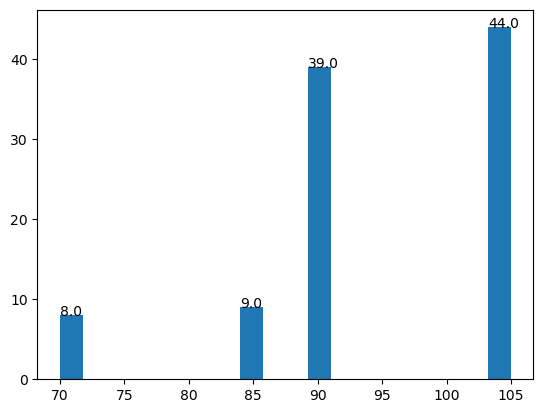

Variance Large Scn Tree: 113.68 (avg 94.55 sd 10.7)

Arc 0 - 6 	 time:  1.32   =?= avg: 1.32  c=  0.05 	 var=c*time:  0.07  =?= 0.07
Arc 6 - 11 	 time:  1.02   =?= avg: 1.02  c=  0.05 	 var=c*time:  0.05  =?= 0.05
Arc 11 - 10 	 time:  0.95   =?= avg: 0.95  c=  0.05 	 var=c*time:  0.05  =?= 0.05
Arc 10 - 20 	 time:  2.64   =?= avg: 2.64  c=  0.05 	 var=c*time:  0.13  =?= 0.13
Arc 0 - 5 	 time:  2.92   =?= avg: 2.92  c=  0.05 	 var=c*time:  0.15  =?= 0.15
Arc 5 - 20 	 time:  4.46   =?= avg: 4.46  c=  0.05 	 var=c*time:  0.22  =?= 0.23
Arc 0 - 12 	 time:  1.24   =?= avg: 1.24  c=  0.05 	 var=c*time:  0.06  =?= 0.06
Arc 12 - 13 	 time:  1.35   =?= avg: 1.35  c=  0.05 	 var=c*time:  0.07  =?= 0.07
Arc 13 - 20 	 time:  1.71   =?= avg: 1.72  c=  0.05 	 var=c*time:  0.09  =?= 0.09
Arc 0 - 9 	 time:  3.29   =?= avg: 3.28  c=  0.05 	 var=c*time:  0.16  =?= 0.16
Arc 9 - 20 	 time:  3.75   =?= avg: 3.74  c=  0.05 	 var=c*time:  0.19  =?= 0.19


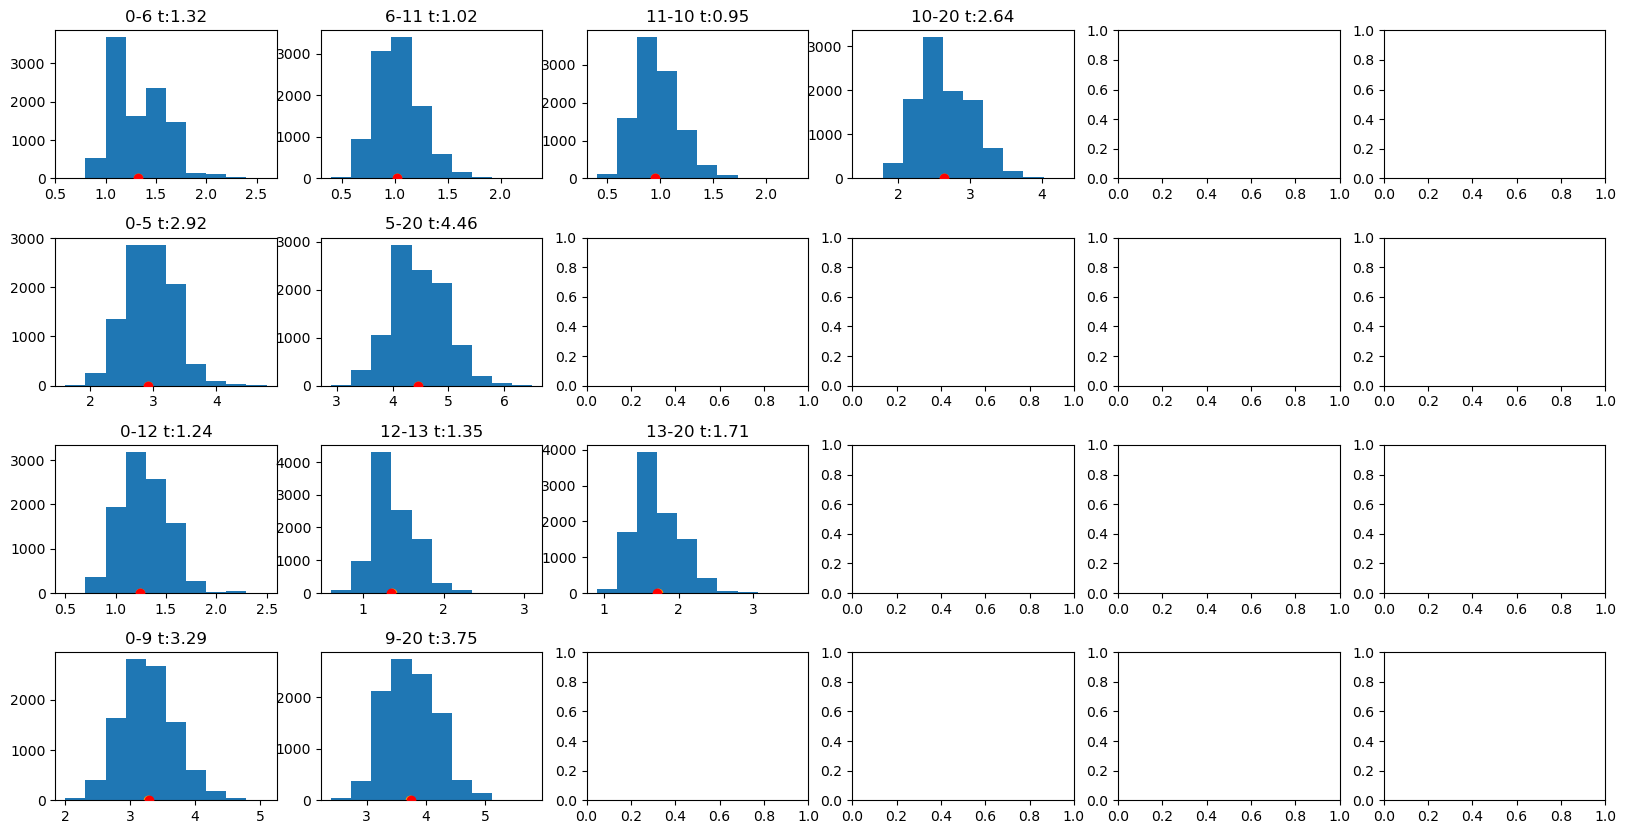

Large tree 4 with stoch OF 94.55 det OF equiv 105 Std: 1.1

Py Simulator average value:  95.4  - std  10.9  - avg reliability  85.7
SAA solution in  3026 sec.


In [19]:
print("\n---------------------- EVALUATE THE BEST SP SOLUTION IN A LARGE TREE  with ",S_large," scn\n")
        
# *** Choose the solution with best objective value ***
best_replica = Z_Rsim.idxmax()           # Use the information of a fast simulation (python)
print("Best solution: ",best_replica+1," with SP objective function: ",Z_R[best_replica]," - ", Z_Rsim[best_replica])

# Fix the value of the 1st stage variables
for i,j,k in instanceLarge.A*instanceLarge.M:
    instanceLarge.x[i,j,k].fix(x_r[best_replica,i,j,k])
    instanceLarge.y[i].fix(  y_r[best_replica,i,k])
    
#instanceLarge.preprocess();  # Update to new values (required in lower versions of Pyomo)
    
results_SPlarge = opt.solve(instanceLarge, tee=False )
print("   Solver time: ",round(results_SPlarge.solver.time,2))

# Store the results
#instanceLarge.solutions.load_from(results_SPlarge)
    
# Compute metrics ----------------------------------------------------------------------
utility_det_large = round(sum(instanceLarge.utility[j]*instanceLarge.x[i,j,k].value for (i,j,k) in instanceLarge.A*instanceLarge.M),1)
utility_sto_large = round(instanceLarge.Total_Utility_Stoch(),2)
Z_R2stg = utility_sto_large
V_R2stg = compute_variance(instanceLarge)
V_R2stg = V_R2stg/instanceLarge.nScn # The variance of the estimator is divided by the sample size

print4simulator(instanceLarge)
[avg_rew, std_rew, min_rew, max_rew, avg_rel] = simulate_sol(instanceName,num_sim, plot_time_dist = True)

print("Large tree " + str(best_replica+1) + " with stoch OF " + str(utility_sto_large) +\
      " det OF equiv " + str(utility_det_large) + " Std: " + str(round(math.sqrt(V_R2stg),1)) +"\n")
print("Py Simulator average value: ",avg_rew,   " - std ", std_rew, " - avg reliability ", avg_rel)

TotalTime = round(time.time() - StartTime)
print("SAA solution in ", TotalTime, "sec.")

## Analysis of the solutions found

Which solutions have been found?

In [20]:
rep_sol = pd.DataFrame({'Z_det'  : Z_det,
                        'Z_R'    : Z_R,
                        'Z_Rsim': Z_Rsim,
                        'V_Rsim': V_Rsim}, 
                       columns = ['Z_det', 'Z_R','Z_Rsim','V_Rsim'])
print(rep_sol)

   Z_det   Z_R  Z_Rsim  V_Rsim
0    105  99.4    92.2  0.0303
1    105  98.2    95.5  0.0117
2    105  98.2    94.7  0.0151
3    105  96.6    95.6  0.0119
4    120  95.8    82.9  0.0408
5    105  99.2    92.3  0.0256
6    105  93.8    95.2  0.0123
7    105  99.2    95.2  0.0123
8    105  98.6    95.5  0.0119
9    105  94.8    90.8  0.0299


Simulate the **best solution** chosen with the Python simulator.

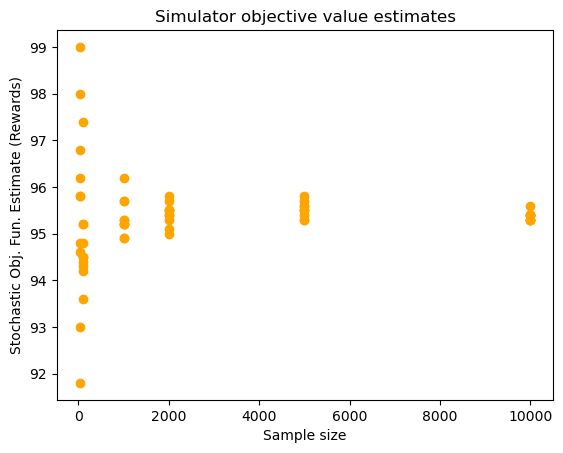

In [21]:
nsims = np.repeat([25, 100, 1000, 2000, 5000, 10000], 10)
avg_rew_sims = np.zeros(len(nsims))
std_rew_sims = np.zeros(len(nsims))
min_rew_sims = np.zeros(len(nsims))
max_rew_sims = np.zeros(len(nsims))
rel_rew_sims = np.zeros(len(nsims))
for r in range(len(nsims)):
    [avg_rew, std_rew, min_rew, max_rew, avg_rel] = simulate_sol(instanceName,nsims[r])
    avg_rew_sims[r] = avg_rew
    std_rew_sims[r] = std_rew
    min_rew_sims[r] = min_rew
    max_rew_sims[r] = max_rew
    rel_rew_sims[r] = avg_rel
    

# Plot the objective estimates with the sample size used
x = nsims
y = avg_rew_sims

plt.scatter(x,y, color = 'orange')
plt.title('Simulator objective value estimates')
plt.xlabel('Sample size')
plt.ylabel('Stochastic Obj. Fun. Estimate (Rewards)')
plt.savefig('./output/'+instanceName.replace('.','_')+'_simulator.png')
plt.show()

## Compute the SAA intervals 

Because we are maximazing, the lower bound of the optimal stochastic objective function is the expected value of a particular solution. 

To compute the **lower bound**, we choose the solution with the best SP objective value. Then, this solution is evaluated in a large number of scenarios. The expected value is the average value and the variance of this estimate the variance of the value provided at each scenario.

* In this implementation, we compute for each replica the expected value with the simulator.
* Because the first stage variables are fixed, the large problem is equivalent to assess a particular set of routes in $S_{2stg}$ independent scenarios.
* This evaluation (it is not really a new optimization problem) is performed very fast, but it takes a lot of time to build the model. Therefore an external simulator can be used to perform this calculations.
* The objective function is already the $Z_{S_{2stg}}$ value if the optimization problem is used, or the average value of the ${S_{2stg}}$ simulations.
* The variance of the estimator of the lower bound is computed as the variance of the values of each scenario divided by the sample size (the larger is the number of simulations, the more confident we are about the average value observed).

$$
\hat{Z}_{S_{2stg}}(\hat{x}) = \frac{1}{\vert S_{2st} \vert} \sum_{s=1}^{S_{2stg}} (\sum_{k=1}^m r^{ks})
$$

The **upper bound** is the average of the objective function values found in each replica:
$$
\overline{Z}_{S} = \frac{1}{R}\sum_{r=1}^R Z_S^r
$$
and the variance of the lower bound:
$$
\sigma^2_{Z_{S}} = \frac{1}{R(R-1)} \sum_{r=1}^R (\overline{Z}_S - Z_S^r)^2
$$

In [22]:
# Bound computed with the instanceLarge (not used now, more than 100 scenarios are needed)
#lower_bound     = Z_R2stg
#lower_bound_var = round(V_R2stg,2)

# Bound computed with the simulator
lower_bound     = Z_Rsim[best_replica]
lower_bound_var = V_Rsim[best_replica]

In [23]:
upper_bound     = round(np.mean(Z_R),2)
upper_bound_var = round(np.var(Z_R, ddof=1)/len(Z_R),2)

In [24]:
gap     = round(upper_bound - lower_bound,2)
gap_var = upper_bound_var + lower_bound_var
gap_sd  = round(sqrt(gap_var),2)

In [25]:
print("Best estimate - replica", best_replica+1," (",Z_Rsim[best_replica]," )\t LB\t", lower_bound, " UB \t", upper_bound, "\t --> gap = ", gap)
print("\t\t\t\tVar(LB) ",lower_bound_var, " \tVar(UB) ", upper_bound_var, "\t --> sd(gap) = ", gap_sd )

Best estimate - replica 4  ( 95.6  )	 LB	 95.6  UB 	 97.38 	 --> gap =  1.78
				Var(LB)  0.0119  	Var(UB)  0.4 	 --> sd(gap) =  0.64


## Analysis of the solution chosen
The selected solution is evaluated under several scenarios.

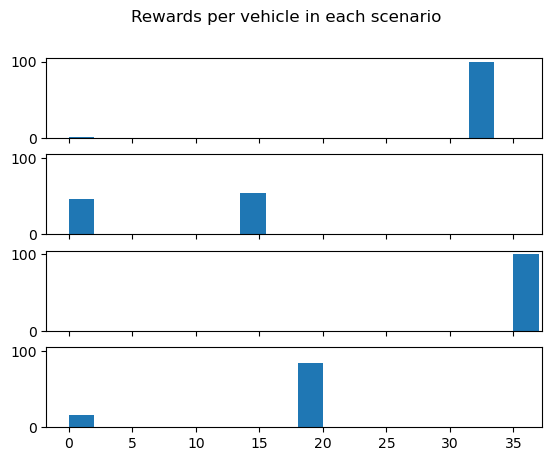

In [26]:
# Check reward distribution (with the large tree values - not the simulated)
reward = plot_reward_instance(instanceLarge)

Vehicle 1 Routes fulfilled 99.0% - 1 failures out of 100
Vehicle 2 Routes fulfilled 54.0% - 46 failures out of 100
Vehicle 3 Routes fulfilled 100.0% - 0 failures out of 100
Vehicle 4 Routes fulfilled 84.0% - 16 failures out of 100


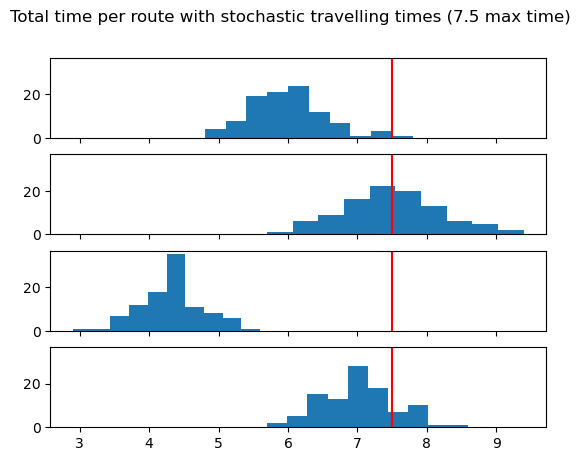

In [27]:
# Check time distribution
route_time = plot_total_time(instanceLarge)